## Part 1 Predicting Tennis Serve Outcomes

아래의 로직으로 코드가 수행됩니다

1. 데이터 수집 준비 
2. 데이터 라벨링 및 전처리
3. 프레임 추출
4. 프레임 로드 및 추가 전처리
5. 모델링 및 결과
6. 모델 비교


* 영상 데이터 다운로드 경로
1. [Data for Project](https://drive.google.com/drive/folders/1-rfgudMgdzlRARMM11O5Pwyv5OCMrSbN?usp=sharing)
 

---
# 1. 데이터 수집 준비

테니스 경기와 포인트 데이터를 다양한 소스에서 가져오고 필요한 데이터를 필터링합니다. \
2010년부터 2023년 사이의 경기 데이터만 선택하고, 임의로 32개의 경기를 선택합니다. 

In [20]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import PIL
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Reshape, InputLayer
from tensorflow.keras.layers import ConvLSTM2D, Dropout
from keras.layers import InputLayer
import random
import shutil
import tensorflow as tf
from tensorflow.keras.utils import plot_model

pd.set_option('display.max_columns', None)

In [21]:
# 테니스 경기 데이터를 읽어오는 코드
df_matches_all = pd.read_csv('../tennis_MatchChartingProject/charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_matches_all.head()

,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Gender,Date,Tournament,Round,Time,Court,Surface,Umpire,Best of,Final TB?,Charted by
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,Novak Djokovic,Ben Shelton,R,L,M,20230908,US Open,SF,3:15 PM,Ashe,Hard,L. Engzell,5,A,BG
1,20230905-M-US_Open-QF-Novak_Djokovic_-Taylor_F...,Novak Djokovic,Taylor Fritz,R,R,M,20230905,US Open,QF,1:50 PM,Ashe,Hard,D. Dumusois,5,A,BG
2,20230831-M-US_Open-R64-Hubert_Hurkacz-Jack_Draper,Hubert Hurkacz,Jack Draper,R,L,M,20230831,US Open,R64,11:10 AM,12,Hard,Greg Allensworth,5,A,Carrie
3,20230829-M-US_Open-R128-Hubert_Hurkacz-Marc_An...,Hubert Hurkacz,Marc Andrea Huesler,R,L,M,20230829,US Open,R128,5:55 PM,10,Hard,Scotty Moore,5,A,Carrie
4,20230829-M-US_Open-R128-Grigor_Dimitrov-Alex_M...,Grigor Dimitrov,Alex Molcan,R,L,M,20230829,US Open,R128,NaN,7,Hard,M. Veljovic,5,A,BG


In [22]:
# 매치 데이터에서 2010년부터 2023년까지의 경기만 선택

# match_id에서 연도를 추출하여 datetime 형태로 변환
df_matches_all['Year'] = pd.to_datetime(df_matches_all['match_id'].str[:4], format='%Y')

# 연도를 기준으로 2010년에서 2023년 사이의 데이터만 필터링
df_matches = df_matches_all[(df_matches_all['Year'] >= '2010') & (df_matches_all['Year'] <= '2023')]

# 'Year' 컬럼이 더 이상 필요 없으면 제거
df_matches = df_matches.drop(columns=['Year'])

# 필터링된 데이터프레임을 표시
df_matches.head()


,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Gender,Date,Tournament,Round,Time,Court,Surface,Umpire,Best of,Final TB?,Charted by
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,Novak Djokovic,Ben Shelton,R,L,M,20230908,US Open,SF,3:15 PM,Ashe,Hard,L. Engzell,5,A,BG
1,20230905-M-US_Open-QF-Novak_Djokovic_-Taylor_F...,Novak Djokovic,Taylor Fritz,R,R,M,20230905,US Open,QF,1:50 PM,Ashe,Hard,D. Dumusois,5,A,BG
2,20230831-M-US_Open-R64-Hubert_Hurkacz-Jack_Draper,Hubert Hurkacz,Jack Draper,R,L,M,20230831,US Open,R64,11:10 AM,12,Hard,Greg Allensworth,5,A,Carrie
3,20230829-M-US_Open-R128-Hubert_Hurkacz-Marc_An...,Hubert Hurkacz,Marc Andrea Huesler,R,L,M,20230829,US Open,R128,5:55 PM,10,Hard,Scotty Moore,5,A,Carrie
4,20230829-M-US_Open-R128-Grigor_Dimitrov-Alex_M...,Grigor Dimitrov,Alex Molcan,R,L,M,20230829,US Open,R128,NaN,7,Hard,M. Veljovic,5,A,BG


In [23]:
# 2010년대와 2020년대 포인트 데이터를 읽어와 병합
df_points_2020s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2020s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_points_2020s.head()

C:\Users\xmars\AppData\Local\Temp\ipykernel_484\504118484.py:2: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points_2020s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2020s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')


,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,6f2n#,NaN,Roof closed,0,NaN,1,NaN,False,False,False,True,False,False,1,1,1
1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0,0,15-0,1 (2),1,0,NaN,1,2,ND,4n,6b19f1b2s1f+3f2j2*,NaN,0,0.0,0,1.0,False,False,True,False,False,False,2,0,8
2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4d,4b+28f2o1*,NaN,0,0.0,0,1.0,False,False,True,False,False,False,2,0,4
3,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,4,0,0,0,0,15-30,1 (4),1,0,NaN,1,2,ND,6s28f3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,1,1,3
4,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,5,0,0,0,0,30-30,1 (5),1,0,NaN,1,2,ND,4b37b-3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,1,1,3


In [24]:
df_points_2010s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2010s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_points_2010s.head()

C:\Users\xmars\AppData\Local\Temp\ipykernel_484\3349779608.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points_2010s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2010s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')


,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,1,0,0,0,0.0,0-0,1 (1),1,0,NaN,1,2,RN,4n,4b1b1b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,3
1,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,2,0,0,0,0.0,15-0,1 (2),1,0,NaN,1,2,RN,5n,5f28f2b1b1b2f3f3d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,7
2,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,3,0,0,0,0.0,30-0,1 (3),1,0,NaN,1,2,RN,4C,NaN,NaN,0,NaN,1,NaN,False,False,False,False,False,False,1,1,1
3,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,4,0,0,0,0.0,40-0,1 (4),1,0,NaN,1,2,RN,4r2d#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,1
4,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,5,0,0,1,0.0,0-0,2 (1),1,0,NaN,2,1,DS,5d,c4b1b1d!@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,0,2


In [25]:
# 데이터프레임을 연결하여 하나의 데이터프레임으로 만듦
df_points = pd.concat([df_points_2020s, df_points_2010s])

# 연결된 데이터프레임의 인덱스를 재설정
df_points.reset_index(drop=True, inplace=True)

# 병합된 데이터프레임의 마지막 부분을 표시
df_points.tail()

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
551784,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,119,0,1,3,5.0,AD-40,19,1,0,NaN,1,2,RF,4d,4b3n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1.0
551785,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,120,0,1,4,5.0,0-0,20,1,0,NaN,2,1,ND,5d,6f1w#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,2,1,1.0
551786,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,121,0,1,4,5.0,15-0,20,1,0,NaN,2,1,ND,5s38b2f1f1f2b2b2f1f3b3b+1n@,NaN,NaN,0,NaN,1,NaN,False,False,False,False,True,False,2,1,11.0
551787,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,122,0,1,4,5.0,30-0,20,1,0,NaN,2,1,ND,4f18f1f3b3s3b3s3f+1l1o3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,2,1,11.0
551788,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,123,0,1,4,5.0,40-0,20,1,0,NaN,2,1,ND,6f1w#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,2,1,1.0


In [26]:
# 무작위로 32개의 경기를 선택
match_ids = np.random.randint(0, len(df_matches), 32)
df_matches.iloc[match_ids, :]['match_id'].values

array(['20140902-M-Shanghai_CH-R32-John_Millman-Ze_Zhang',
       '20230410-M-Monte_Carlo_Masters-R64-Maxime_Cressy-Matteo_Berrettini',
       '20220721-M-Gstaad-R16-Dominic_Thiem-Federico_Delbonis',
       '20210905-M-US_Open-R16-Diego_Schwartzman-Botic_Van_De_Zandschulp',
       '20160820-M-Cincinnati_Masters-SF-Milos_Raonic-Andy_Murray',
       '20220212-M-Dallas-QF-Reilly_Opelka-Adrian_Mannarino',
       '20220818-M-Cincinnati_Masters-R16-Jannik_Sinner_-Felix_Auger_Aliassime',
       '20130509-M-Madrid_Masters-R16-Grigor_Dimitrov-Stan_Wawrinka',
       '20220905-M-US_Open-R16-Marin_Cilic-Carlos_Alcaraz',
       '20190220-M-Rio_de_Janeiro-R16-Aljaz_Bedene-Thiago_Monteiro',
       '20140103-M-Brisbane-QF-Marin_Cilic-Kei_Nishikori',
       '20190205-M-Sofia-R32-Gael_Monfils-Viktor_Troicki',
       '20161018-M-Stockholm-R32-Fernando_Verdasco-Mikael_Ymer',
       '20230712-M-Wimbledon-QF-Christopher_Eubanks-Daniil_Medvedev',
       '20220106-M-Melbourne-R16-Maxime_Cressy_-Reilly_Opelka_

데이터 셋에서 균일한 대표성을 확보하고 편향을 최소화하기 위해 처음에는 무작위로 경기 목록을 선정했지만, 모든 경기의 비디오를 찾을 수 없었습니다. \
따라서 사용 가능한 비디오가 있는 경기만을 다시 선택하였고, 이를 위해 TennisTV 웹사이트 등에서 영상을 수집하였습니다

In [27]:
# 사용할 경기 ID 목록을 정의
# 추가로 필요한 다른 경기 ID를 이 배열에 계속해서 추가

match_ids_new = [
    '20190110-M-Sydney-QF-John_Millman-Gilles_Simon',
    '20230224-M-Doha-SF-Jiri_Lehecka-Andy_Murray',
    '20200225-M-Dubai-R32-Hubert_Hurkacz-Alexander_Bublik',
    '20190307-M-Indian_Wells_Masters-R128-Felix_Auger_Aliassime-Cameron_Norrie',
    '20180425-M-Barcelona-R32-Pablo_Carreno_Busta-Benoit_Paire',
    '20190919-M-St_Petersburg-R16-Evgeny_Donskoy-Daniil_Medvedev',
    '20170219-M-Buenos_Aires-F-Alexandr_Dolgopolov-Kei_Nishikori',
    '20180228-M-Acapulco-R16-Juan_Martin_Del_Potro-David_Ferrer',
    '20230818-M-Cincinnati_Masters-R16-Novak_Djokovic-Gael_Monfils',
    '20220226-M-Dubai-F-Andrey_Rublev-Jiri_Vesely',
    '20190301-M-Sao_Paulo-QF-Casper_Ruud-Hugo_Dellien',
    '20220212-M-Dallas-SF-John_Isner-Reilly_Opelka',
    '20180621-M-Queens_Club-R16-Nick_Kyrgios-Kyle_Edmund',
    '20230812-M-Canada_Masters-SF-Jannik_Sinner-Tommy_Paul',
    '20230806-M-Washington-F-Daniel_Evans-Tallon_Griekspoor', 
    '20230215-M-Rotterdam-R16-Hubert_Hurkacz-Grigor_Dimitrov',
    '20220318-M-Indian_Wells_Masters-QF-Grigor_Dimitrov-Andrey_Rublev',
    '20220810-M-Canada_Masters-R32-Roberto_Bautista_Agut-Jenson_Brooksby',
    '20230619-M-Halle-R32-Marcos_Giron-Daniil_Medvedev',
    '20230613-M-Stuttgart-R32-Yibing_Wu-Nick_Kyrgios',
    '20230515-M-Rome_Masters-R32-Bernabe_Zapata_Miralles-Daniil_Medvedev',
    '20230407-M-Estoril-R16-Ben_Shelton_-Dominic_Thiem', 
    '20230410-M-Monte_Carlo_Masters-R64-Maxime_Cressy-Matteo_Berrettini',
    '20220808-M-Canada_Masters-R64-Emil_Ruusuvuori_-Stan_Wawrinka',
    '20220807-M-Washington-SF-Yoshihito_Nishioka-Andrey_Rublev',
    '20150417-M-Monte_Carlo_Masters-QF-Grigor_Dimitrov-Gael_Monfils',
    '20230421-M-Banja_Luka-QF-Jiri_Lehecka-Miomir_Kecmanovic',
    '20180504-M-Munich-QF-Roberto_Bautista_Agut-Philipp_Kohlschreiber',
    '20230423-M-Munich-F-Botic_Van_De_Zandschulp-Holger_Rune',
    '20200229-M-Dubai-F-Novak_Djokovic-Stefanos_Tsitsipas',
    '20151101-M-Basel-F-Rafael_Nadal-Roger_Federer',
    '20221024-M-Basel-R32-Brandon_Nakashima_-David_Goffin_'
]

df_matches[df_matches['match_id'].isin(match_ids_new)]['match_id'].values

array(['20230818-M-Cincinnati_Masters-R16-Novak_Djokovic-Gael_Monfils',
       '20230812-M-Canada_Masters-SF-Jannik_Sinner-Tommy_Paul',
       '20230806-M-Washington-F-Daniel_Evans-Tallon_Griekspoor',
       '20230619-M-Halle-R32-Marcos_Giron-Daniil_Medvedev',
       '20230613-M-Stuttgart-R32-Yibing_Wu-Nick_Kyrgios',
       '20230515-M-Rome_Masters-R32-Bernabe_Zapata_Miralles-Daniil_Medvedev',
       '20230423-M-Munich-F-Botic_Van_De_Zandschulp-Holger_Rune',
       '20230421-M-Banja_Luka-QF-Jiri_Lehecka-Miomir_Kecmanovic',
       '20230410-M-Monte_Carlo_Masters-R64-Maxime_Cressy-Matteo_Berrettini',
       '20230407-M-Estoril-R16-Ben_Shelton_-Dominic_Thiem',
       '20230224-M-Doha-SF-Jiri_Lehecka-Andy_Murray',
       '20230215-M-Rotterdam-R16-Hubert_Hurkacz-Grigor_Dimitrov',
       '20221024-M-Basel-R32-Brandon_Nakashima_-David_Goffin_',
       '20220810-M-Canada_Masters-R32-Roberto_Bautista_Agut-Jenson_Brooksby',
       '20220808-M-Canada_Masters-R64-Emil_Ruusuvuori_-Stan_Wawrinka',
 

---
## 2. 데이터 라벨링 및 전처리

테니스 서브 데이터를 유형별(에이스, 폴트, 리턴 등)로 정리합니다.    \
get_data 함수로 각 서브 유형별 포인트를 필터링합니다.   \
프레임 추출을 위해 동영상에서 7개 프레임을 랜덤하게 선택하고 저장합니다.    

In [28]:
# 서브 유형별로 포인트를 추출하는 함수 정의

def get_data(match, num, starting_side):
    match_name = df_matches.iloc[match, :]['match_id'] 
    points = df_points.loc[df_points['match_id'] == match_name, :] 

     # 플레이어가 같은 코트 쪽에서 시작한 포인트 필터링
    valid_pts = []
    for pt in points[['Pt']].values:
        total = points.loc[points['Pt'] == pt[0], 'Gm1'].values + points.loc[points['Pt'] == pt[0], 'Gm2'].values
        if starting_side == 'near':
            if total in [0, 1, 4, 5, 8, 9, 12]:
                valid_pts.append(pt[0])
        else: 
            if total in [2, 3, 6, 7, 10, 11]:
                valid_pts.append(pt[0])
    
    # 필터링된 포인트 중에서 첫 번째 세트에 해당하는 포인트만 선택
    points = points[points['Pt'].isin(valid_pts)]
    points = points.loc[(points['Set1'] == 0) & (points['Set2'] == 0), :]

    # 서브 유형별로 샘플 추출 (에이스, 폴트, 리턴 등)
    serv1 = points.loc[points['Svr'] == 1, :].copy()
    serv2 = points.loc[points['Svr'] == 2, :].copy()

    # 서버1
    #get aces 1
    serv1_aces = serv1.loc[(serv1['1stIn'] == 1) & ((serv1['isAce'] == True) | (serv1['isUnret'] == True)), :]
    serv1_aces_pts = serv1_aces[['Pt']].values.reshape(len(serv1_aces))
    np.random.shuffle(serv1_aces_pts)
    serv1_aces_sample = list(serv1_aces_pts)[:num]
    if len(serv1_aces_sample) == 0:
        serv1_aces_sample = ['NA']

    #get faults 1
    serv1_fault = serv1.loc[serv1['1stIn'] == 0, :]
    serv1_fault_pts = serv1_fault[['Pt']].values.reshape(len(serv1_fault))
    np.random.shuffle(serv1_fault_pts)
    serv1_fault_sample = list(serv1_fault_pts)[:num]
    if len(serv1_fault_sample) == 0:
        serv1_fault_sample = ['NA']

    #get returned serves 1
    serv1['rallyCount'] = serv1['rallyCount'].astype(int)  # Convert 'rallyCount' to integer type
    serv1_returned = serv1.loc[(serv1['1stIn'] == 1) & (serv1['rallyCount'] > 1), :]
    serv1_returned_pts = serv1_returned[['Pt']].values.reshape(len(serv1_returned))
    np.random.shuffle(serv1_returned_pts)
    serv1_return_sample = list(serv1_returned_pts)[:num]
    if len(serv1_return_sample) == 0:
        serv1_return_sample = ['NA']

    #get unreturned serves 1
    serv1_unreturned = serv1.loc[(serv1['1stIn'] == 1) & (serv1['rallyCount'] == 1), :]
    serv1_unreturned_pts = serv1_unreturned[['Pt']].values.reshape(len(serv1_unreturned))
    np.random.shuffle(serv1_unreturned_pts)
    serv1_unreturned_sample = list(serv1_unreturned_pts)[:num] 
    if len(serv1_unreturned_sample) == 0:
        serv1_unreturned_sample = ['NA']
    
    # 서버2
    #get aces 2
    serv2_aces = serv2.loc[(serv2['1stIn'] == 1) & ((serv2['isAce'] == True) | (serv2['isUnret'] == True)), :]
    serv2_aces_pts = serv2_aces[['Pt']].values.reshape(len(serv2_aces))
    np.random.shuffle(serv2_aces_pts)
    serv2_aces_sample = list(serv2_aces_pts)[:num]
    if len(serv2_aces_sample) == 0:
        serv2_aces_sample = ['NA']
    
    #get faults 2
    serv2_fault = serv2.loc[serv2['1stIn'] == 0, :]
    serv2_fault_pts = serv2_fault[['Pt']].values.reshape(len(serv2_fault))
    np.random.shuffle(serv2_fault_pts)
    serv2_fault_sample = list(serv2_fault_pts)[:num]
    if len(serv2_fault_sample) == 0:
        serv2_fault_sample = ['NA']
    
    #get returned serves 2
    serv2['rallyCount'] = serv2['rallyCount'].astype(int)  
    serv2_returned = serv2.loc[(serv2['1stIn'] == 1) & (serv2['rallyCount'] > 1), :]
    serv2_returned_pts = serv2_returned[['Pt']].values.reshape(len(serv2_returned))
    np.random.shuffle(serv2_returned_pts)
    serv2_return_sample = list(serv2_returned_pts)[:num]
    if len(serv2_return_sample) == 0:
        serv2_return_sample = ['NA']

    #get unreturned serves 2
    serv2_unreturned = serv2.loc[(serv2['1stIn'] == 1) & (serv2['rallyCount'] == 1), :]
    serv2_unreturned_pts = serv2_unreturned[['Pt']].values.reshape(len(serv2_unreturned))
    np.random.shuffle(serv2_unreturned_pts)
    serv2_unreturned_sample = list(serv2_unreturned_pts)[:num] 
    if len(serv2_unreturned_sample) == 0:
        serv2_unreturned_sample = ['NA']
    
    # 각 서브 유형별로 추출된 샘플을 반환
    return serv1_aces_sample, serv1_fault_sample, serv1_return_sample, serv1_unreturned_sample, \
        serv2_aces_sample, serv2_fault_sample, serv2_return_sample, serv2_unreturned_sample

In [29]:
# match_ids_new 목록에 있는 각 경기 ID에 대해 반복

for match_id in match_ids_new:
    match_index = df_matches[df_matches['match_id'] == match_id].index[0]
    serv1_aces_sample, serv1_fault_sample, serv1_return_sample, serv1_unreturned_sample, \
    serv2_aces_sample, serv2_fault_sample, serv2_return_sample, serv2_unreturned_sample = \
    get_data(match_index, 1, 'near')

    # 추출된 샘플 데이터를 출력
    print([serv1_aces_sample[0], serv1_fault_sample[0], serv1_return_sample[0], serv1_unreturned_sample[0], \
           serv2_aces_sample[0], serv2_fault_sample[0], serv2_return_sample[0], serv2_unreturned_sample[0]])

['NA', 4, 2, 40, 'NA', 53, 26, 27]
[3, 2, 10, 3, 'NA', 14, 41, 44]
['NA', 25, 27, 8, 'NA', 11, 35, 34]
[6, 1, 49, 21, 'NA', 31, 27, 30]
['NA', 28, 29, 27, 'NA', 34, 33, 32]
['NA', 48, 26, 1, 7, 12, 10, 7]
['NA', 31, 7, 84, 'NA', 16, 13, 37]
[3, 25, 21, 2, 'NA', 28, 7, 30]
[48, 50, 30, 28, 13, 10, 6, 13]
[41, 2, 5, 25, 27, 30, 7, 26]
['NA', 2, 26, 27, 'NA', 33, 15, 34]
[45, 2, 3, 4, 48, 9, 7, 48]
[42, 23, 43, 62, 10, 64, 67, 48]
['NA', 1, 3, 59, 'NA', 30, 64, 60]
[28, 2, 27, 28, 49, 50, 54, 7]
[43, 47, 44, 68, 27, 49, 67, 30]
['NA', 55, 32, 28, 38, 8, 37, 9]
[5, 47, 26, 25, 60, 11, 29, 60]
[2, 53, 27, 30, 56, 8, 11, 39]
[33, 2, 1, 8, 62, 61, 36, 11]
['NA', 22, 21, 5, 'NA', 6, 33, 'NA']
['NA', 1, 22, 25, 'NA', 9, 8, 30]
[62, 29, 55, 60, 'NA', 39, 35, 8]
['NA', 5, 30, 29, 35, 36, 7, 35]
[60, 1, 2, 7, 40, 42, 13, 14]
['NA', 2, 3, 'NA', 32, 31, 27, 30]
[8, 5, 32, 8, 14, 36, 43, 14]
[2, 4, 3, 51, 'NA', 11, 13, 41]
[60, 62, 2, 59, 'NA', 71, 38, 39]
['NA', 4, 28, 3, 35, 38, 10, 12]
['NA', 57, 

In [30]:
# '20190110-M-Sydney-QF-John_Millman-Gilles_Simon' 경기에 대한 포인트 데이터를 필터링
points = df_points.loc[df_points['match_id'] == '20190110-M-Sydney-QF-John_Millman-Gilles_Simon', :]

# 포인트 번호가 41인 데이터를 조회
points.loc[points['Pt'] == 41, :]

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
335663,20190110-M-Sydney-QF-John_Millman-Gilles_Simon,41,0,0,3,5.0,30-15,9 (4),1,0,NaN,1,2,JM,4d,4b37b3f1f1f1f1f1f1f1f1f2f2f3b3b2b2b2b2d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,18


---
## 3. 프레임 추출

특정 동영상에서 서브 장면이 포함된 프레임을 추출하여 데이터셋을 구성합니다. \
랜덤하게 프레임을 선택하고, 선택된 프레임을 이미지 파일로 저장합니다. \
프레임 추출 과정에서 일부 프레임이 누락되거나 에러가 발생할 경우, 해당 프레임을 다시 처리하거나 대체 프레임을 선택합니다. 

In [31]:
# 동영상에서 프레임을 추출하는 함수
def extract_frames(video_path, output_path, num_frames=7):
    random.seed(42)  # 시드 설정
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # 동영상의 총 프레임 수 가져오기

    extracted_frames = 0  # 추출된 프레임 수를 추적하는 카운터
   
    # 7개의 프레임이 추출될 때까지 랜덤으로 추출
    while extracted_frames < num_frames:
        frame_index = random.randint(0, total_frames - 1)
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        success, image = vidcap.read()
        if success:
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            cv2.imwrite(os.path.join(output_path, f"frame{extracted_frames}.jpg"), image)
            extracted_frames += 1
   
    vidcap.release()
    if extracted_frames != num_frames:
        print(f"Warning: Number of frames extracted ({extracted_frames}) is not equal to the desired number ({num_frames})")
        failed_path = "../failed_videos"  # 실패한 영상 저장 경로
        if not os.path.exists(failed_path):
            os.makedirs(failed_path)
        shutil.move(video_path, failed_path)  # 실패한 영상 이동
        if os.path.exists(output_path):
            shutil.rmtree(output_path)  # 관련 프레임 폴더 삭제

# 프레임 데이터 및 라벨 데이터 저장 경로
npy_data_dir = "../frames_data"
X_file_path = os.path.join(npy_data_dir, "X.npy")
y_file_path = os.path.join(npy_data_dir, "y.npy")

# Check if pre-saved .npy files exist
if os.path.exists(X_file_path) and os.path.exists(y_file_path):
    print("Pre-saved frame data found. Loading .npy files...")
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print("프레임 데이터와 라벨 데이터를 성공적으로 로드했습니다.")
else:
    print("No pre-saved frame data found. Generating frames from videos...")

    if os.path.exists("../frames"):
        print("Cleaning up existing frames directory...")
        shutil.rmtree("../frames")  # 이전 결과 삭제
    os.makedirs("../frames")  # 새로 생성

    # 데이터 경로
    data_dirs = ["../data/01_ace", "../data/02_faults", "../data/03_returned", "../data/04_unreturned"]

    X = []  # 특징(프레임)을 저장할 리스트
    y = []  # 라벨을 저장할 리스트
    num_frames_per_video = 7  # 각 동영상에서 추출할 프레임 수

    processed_videos = set()  # 이미 처리한 비디오 파일 저장

    for label, dir_path in enumerate(data_dirs):
        for filename in os.listdir(dir_path):
            if filename.endswith(".mov"):   # .mov 파일인지 확인
                video_path = os.path.join(dir_path, filename)
                frames_output_path = os.path.join("../frames", os.path.basename(dir_path), os.path.splitext(filename)[0])
                
                # 이미 처리된 동영상 건너뛰기
                if filename in processed_videos:
                    print(f"Skipping already processed video: {filename}")
                    continue
                
                extract_frames(video_path, frames_output_path, num_frames=num_frames_per_video)
                
                if os.path.exists(frames_output_path) and len(os.listdir(frames_output_path)) == num_frames_per_video:
                    frame_files = [os.path.join(frames_output_path, frame_file) for frame_file in os.listdir(frames_output_path)]
                    X.extend(frame_files)
                    y.extend([label] * len(frame_files))
                    processed_videos.add(filename)

    X = np.array(X)
    y = np.array(y)

    if not os.path.exists(npy_data_dir):
        os.makedirs(npy_data_dir)
    np.save(X_file_path, X)
    np.save(y_file_path, y)
    print(f"프레임 데이터와 라벨 데이터를 .npy 파일로 저장했습니다: {npy_data_dir}")


# 3D-CNN용 프레임 전처리 함수
def preprocess_frames_for_3dcnn(X_paths, num_frames=7, target_size=(112, 112)):
    print("Preprocessing frames for 3D-CNN input...")
    X_data = []  # 3D-CNN 입력 데이터를 저장할 리스트

    for video_folder in X_paths:
        video_frames = []  # 각 비디오의 프레임 리스트

        for i in range(num_frames):
            frame_file_path = os.path.join(video_folder, f"frame{i}.jpg")
            if os.path.exists(frame_file_path):
                frame = load_img(frame_file_path, target_size=target_size)
                frame = img_to_array(frame) / 255.0  # 정규화
                video_frames.append(frame)
            else:
                video_frames.append(np.zeros((target_size[0], target_size[1], 3)))  # 누락된 프레임은 0으로 채움

        X_data.append(video_frames)

    X_data = np.array(X_data)  # (샘플 수, 프레임 수, 높이, 너비, 채널)
    print(f"Processed 3D-CNN data shape: {X_data.shape}")
    return X_data

# 3D-CNN 데이터 준비
num_frames_per_video = 7  # 각 비디오에서 추출할 프레임 수
X_3d = preprocess_frames_for_3dcnn(X, num_frames=num_frames_per_video, target_size=(112, 112))
y_3d = y  # 레이블은 기존 데이터 사용

# 데이터 저장
final_data_dir = "../preprocessed_data_3d"
if not os.path.exists(final_data_dir):
    os.makedirs(final_data_dir)
np.save(os.path.join(final_data_dir, "X_3d.npy"), X_3d)
np.save(os.path.join(final_data_dir, "y_3d.npy"), y_3d)
print("3D-CNN 데이터 저장 완료!")

No pre-saved frame data found. Generating frames from videos...
Cleaning up existing frames directory...
프레임 데이터와 라벨 데이터를 .npy 파일로 저장했습니다: ../frames_data
Preprocessing frames for 3D-CNN input...
Processed 3D-CNN data shape: (1043, 7, 112, 112, 3)
3D-CNN 데이터 저장 완료!


### * 영상 데이터 확인
* 의미: 원본 영상 파일의 개수.
* 확인 코드:

In [32]:
# 영상 데이터 디렉토리 확인
video_dirs = ["../data/01_ace", "../data/02_faults", "../data/03_returned", "../data/04_unreturned"]

# 각 디렉토리의 영상 파일 개수
for dir_path in video_dirs:
    if os.path.exists(dir_path):
        video_files = [f for f in os.listdir(dir_path) if f.endswith(".mov")]
        print(f"{dir_path}: {len(video_files)}개의 영상 파일")
    else:
        print(f"{dir_path}: 디렉토리가 존재하지 않습니다.")

../data/01_ace: 37개의 영상 파일
../data/02_faults: 38개의 영상 파일
../data/03_returned: 36개의 영상 파일
../data/04_unreturned: 38개의 영상 파일


### * 프레임 데이터 확인
* 의미: 각 영상에서 추출한 프레임 이미지 파일의 개수.
* 확인 코드:

In [33]:
# 프레임 데이터 디렉토리 확인
frame_dirs = ["../frames/01_ace", "../frames/02_faults", "../frames/03_returned", "../frames/04_unreturned"]

# 각 디렉토리의 프레임 파일 개수
total_frames = 0
for dir_path in frame_dirs:
    if os.path.exists(dir_path):
        frame_count = 0
        # os.walk()를 사용해 하위 디렉토리까지 탐색
        for root, _, files in os.walk(dir_path):
            frame_files = [f for f in files if f.endswith(".jpg")]
            frame_count += len(frame_files)
        print(f"{dir_path}: {frame_count}개의 프레임 파일")
        total_frames += frame_count
    else:
        print(f"{dir_path}: 디렉토리가 존재하지 않습니다.")
print(f"총 프레임 파일 개수: {total_frames}")


../frames/01_ace: 259개의 프레임 파일
../frames/02_faults: 266개의 프레임 파일
../frames/03_returned: 252개의 프레임 파일
../frames/04_unreturned: 266개의 프레임 파일
총 프레임 파일 개수: 1043


---
## 4. 프레임 로드 및 추가 전처리

저장된 프레임 이미지를 로드하고, 이미지 크기 조정, 정규화 등 추가 전처리 작업을 수행합니다. \
이러한 전처리 과정을 통해 모델이 이미지 데이터를 더 잘 이해하고 처리할 수 있도록 돕습니다. \
전처리된 프레임은 모델 학습이나 테스트에 사용될 준비가 완료됩니다.

In [34]:
# 프레임을 로드하고 전처리하는 함수
def load_and_preprocess_frames(frame_paths, num_frames_per_video=7, target_size=(112, 112)):
    frames = [] # 전체 프레임 데이터를 저장할 리스트
    for frame_path in frame_paths:
        video_frames = [] # 한 동영상의 프레임 데이터를 저장할 리스트
        for i in range(num_frames_per_video):
             # 프레임 파일 경로 생성
            frame_file_path = os.path.join(frame_path, f"frame{i}.jpg")
            if os.path.exists(frame_file_path):
                # 프레임 로드, 크기 조정, 배열로 변환
                frame = load_img(frame_file_path, target_size=target_size)
                frame = img_to_array(frame) / 255.0  # 픽셀 값을 [0, 1]로 정규화
                video_frames.append(frame)
            else:
                 # 프레임이 없으면 0으로 채워진 배열로 대체
                video_frames.append(np.zeros((target_size[0], target_size[1], 3)))
        frames.append(video_frames)
    return np.array(frames) # numpy 배열로 변환하여 반환

# 미리 전처리된 3D-CNN 데이터 로드
X_3d = np.load("../preprocessed_data_3d/X_3d.npy", allow_pickle=True)
y_3d = np.load("../preprocessed_data_3d/y_3d.npy", allow_pickle=True)

# 학습 데이터와 테스트 데이터로 분할
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(
    X_3d, y_3d, test_size=0.2, random_state=42
)

# 학습 데이터와 테스트 데이터의 크기 출력
print(f"Training data shape: {X_train_preprocessed.shape}")
print(f"Testing data shape: {X_test_preprocessed.shape}")

# 모델 입력 형태에 맞게 데이터 재구성 (필요 시)
input_shape = (7, 112, 112, 3)  # 프레임 수, 높이, 너비, 채널 수
X_train_preprocessed = X_train_preprocessed.reshape(-1, *input_shape)
X_test_preprocessed = X_test_preprocessed.reshape(-1, *input_shape)

# 라벨 데이터를 원-핫 인코딩으로 변환
num_classes = len(np.unique(y_train))  # 레이블 수
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# 라벨 데이터 형태 출력
print(f"Training labels shape: {y_train_encoded.shape}")
print(f"Testing labels shape: {y_test_encoded.shape}")

Training data shape: (834, 7, 112, 112, 3)
Testing data shape: (209, 7, 112, 112, 3)
Training labels shape: (834, 4)
Testing labels shape: (209, 4)


---
## 5. 모델링

3D-CNN과 ConvLSTM 모델을 구성하고, 이전 단계에서 준비된 데이터를 사용하여 모델을 학습시킵니다. \
각 모델의 성능을 평가하기 위해 정확도와 손실을 측정하고, 모델 훈련을 통해 얻은 결과를 분석합니다. \
최종적으로, 모델의 예측 성능을 테스트 데이터셋을 사용하여 검증하고, 두 모델의 성능을 비교하여 더 우수한 모델을 선정합니다.\
이 과정들을 통해 모델의 효율성과 정확성을 극대화하고, 실제 테니스 경기의 서브 상황을 정확히 예측할 수 있는 모델을 개발합니다.

#### Model 1: 3D-CNN


In [14]:
# 입력 데이터의 모양과 분류할 클래스의 수 정의
num_frames_per_video = 7  # 동영상당 프레임 수 
num_classes = 4  # 분류할 클래스 수 
input_shape = (num_frames_per_video, 112, 112, 3)  # (프레임 수, 높이, 너비, 채널 수)

# 모델 아키텍처 정의
model = Sequential([  # Sequential 모델 생성
    InputLayer(input_shape),  # 입력층 정의
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),  
    MaxPooling3D(pool_size=(2, 2, 2)), 
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),  
    MaxPooling3D(pool_size=(2, 2, 2)), 
    Flatten(),  # 다차원 데이터를 1차원으로 펼침
    Dense(96, activation='relu'),  
    Dense(num_classes, activation='softmax')  
])

# 모델 구조를 시각화하여 저장 
plot_model(model, to_file='../assets/model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
# 입력 데이터 정의
input_shape = (num_frames_per_video, 112, 112, 3)

# 모델 아키텍처 정의
model = Sequential([
    InputLayer(input_shape),
    Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2)), 
    Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2)),
    Flatten(),
    Dense(96, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [37]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# 모델 평가
loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
21/21 [==============================] - 90s 4s/step - loss: 1.3864 - accuracy: 0.2114 - val_loss: 1.3863 - val_accuracy: 0.2635
Epoch 2/10
21/21 [==============================] - 94s 4s/step - loss: 1.3863 - accuracy: 0.2354 - val_loss: 1.3862 - val_accuracy: 0.2635
Epoch 3/10
21/21 [==============================] - 90s 4s/step - loss: 1.3863 - accuracy: 0.2534 - val_loss: 1.3863 - val_accuracy: 0.2635
Epoch 4/10
21/21 [==============================] - 96s 5s/step - loss: 1.3863 - accuracy: 0.2249 - val_loss: 1.3862 - val_accuracy: 0.2635
Epoch 5/10
21/21 [==============================] - 92s 4s/step - loss: 1.3863 - accuracy: 0.2534 - val_loss: 1.3862 - val_accuracy: 0.2635
Epoch 6/10
21/21 [==============================] - 92s 4s/step - loss: 1.3863 - accuracy: 0.2534 - val_loss: 1.3862 - val_accuracy: 0.2635
Epoch 7/10
21/21 [==============================] - 91s 4s/step - loss: 1.3863 - accuracy: 0.2534 - val_loss: 1.3862 - val_accuracy: 0.2635
Epoch 8/10
21/21 [==

In [38]:
# 학습 결과(Accuracy 및 Loss)를 시각화
def results_plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(17, 6))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.suptitle('Accuracy and Loss Measurements')

    ax[0].plot(epochs, acc, 'bo', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'ro', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

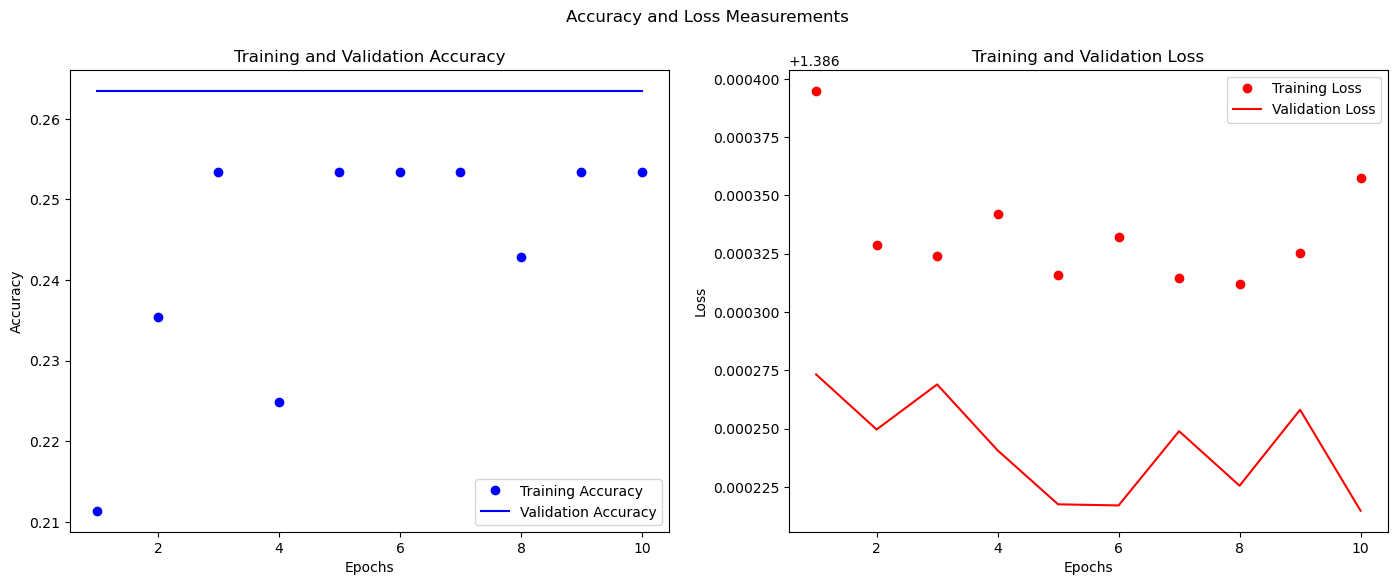

In [39]:
results_plot(history)

In [40]:
# 1. 데이터 분포 확인(전체 데이터[학습/테스트]의 클래스 분포)
unique, counts = np.unique(y_3d, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 259, 1: 266, 2: 252, 3: 266}


In [50]:
# 모델 성능 보고서

#  1. 데이터 분포 확인
# 테스트 데이터에서 클래스 분포 확인
unique, counts = np.unique(y_test, return_counts=True)  # y_test에서 고유 클래스와 해당 개수 확인
print(f"Class distribution in test set: {dict(zip(unique, counts))}")

# 예측값 생성
# - 모델을 사용해 X_test_preprocessed 데이터에 대한 예측 수행
y_pred = model.predict(X_test_preprocessed)  # 3D-CNN 모델로 예측
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 추출 (최대 확률값을 가진 인덱스)
y_true_classes = np.argmax(y_test_encoded, axis=1)  # 실제 클래스 추출

# Classification Report 출력
# - target_names는 클래스 이름을 지정
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("Classification Report for 3D-CNN Model:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names, zero_division=0))


Class distribution in test set: {0: 50, 1: 53, 2: 46, 3: 60}
7/7 [==============================] - 1s 147ms/step
Classification Report for 3D-CNN Model:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        50
     Class 1       0.25      1.00      0.40        53
     Class 2       0.00      0.00      0.00        46
     Class 3       0.00      0.00      0.00        60

    accuracy                           0.25       209
   macro avg       0.06      0.25      0.10       209
weighted avg       0.06      0.25      0.10       209



---
#### Model 2: Convolutional LSTM


In [43]:
# 입력 데이터의 형태와 클래스 수 정의
num_frames_per_video = 7  # 동영상당 프레임 수 
num_classes = 4   # 분류할 클래스 수 
input_shape = (num_frames_per_video, 112, 112, 3)

# 모델 아키텍처 정의
model_2 = Sequential([
    ConvLSTM2D(10, kernel_size=(3, 3), input_shape=input_shape, return_sequences=False),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

#  모델 구조를 시각화하여 저장
plot_model(model_2, to_file='../assets/model_2_plot_LR.png', show_shapes=True, show_layer_names=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
# 입력 데이터 정의
input_shape = (num_frames_per_video, 112, 112, 3)

# 모델 아키텍처 정의
model_2 = Sequential([
    ConvLSTM2D(10, kernel_size=(3,3), input_shape=input_shape),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [45]:
# 모델 컴파일
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history_2 = model_2.fit(X_train_preprocessed, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# 모델 평가
loss, accuracy = model_2.evaluate(X_test_preprocessed, y_test_encoded)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
21/21 [==============================] - 38s 2s/step - loss: 1.3865 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2455
Epoch 2/10
21/21 [==============================] - 30s 1s/step - loss: 1.3863 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2455
Epoch 3/10
21/21 [==============================] - 36s 2s/step - loss: 1.3864 - accuracy: 0.2519 - val_loss: 1.3862 - val_accuracy: 0.2455
Epoch 4/10
21/21 [==============================] - 35s 2s/step - loss: 1.3863 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2455
Epoch 5/10
21/21 [==============================] - 36s 2s/step - loss: 1.3863 - accuracy: 0.2519 - val_loss: 1.3862 - val_accuracy: 0.2455
Epoch 6/10
21/21 [==============================] - 36s 2s/step - loss: 1.3863 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2455
Epoch 7/10
21/21 [==============================] - 33s 2s/step - loss: 1.3863 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2455
Epoch 8/10
21/21 [==

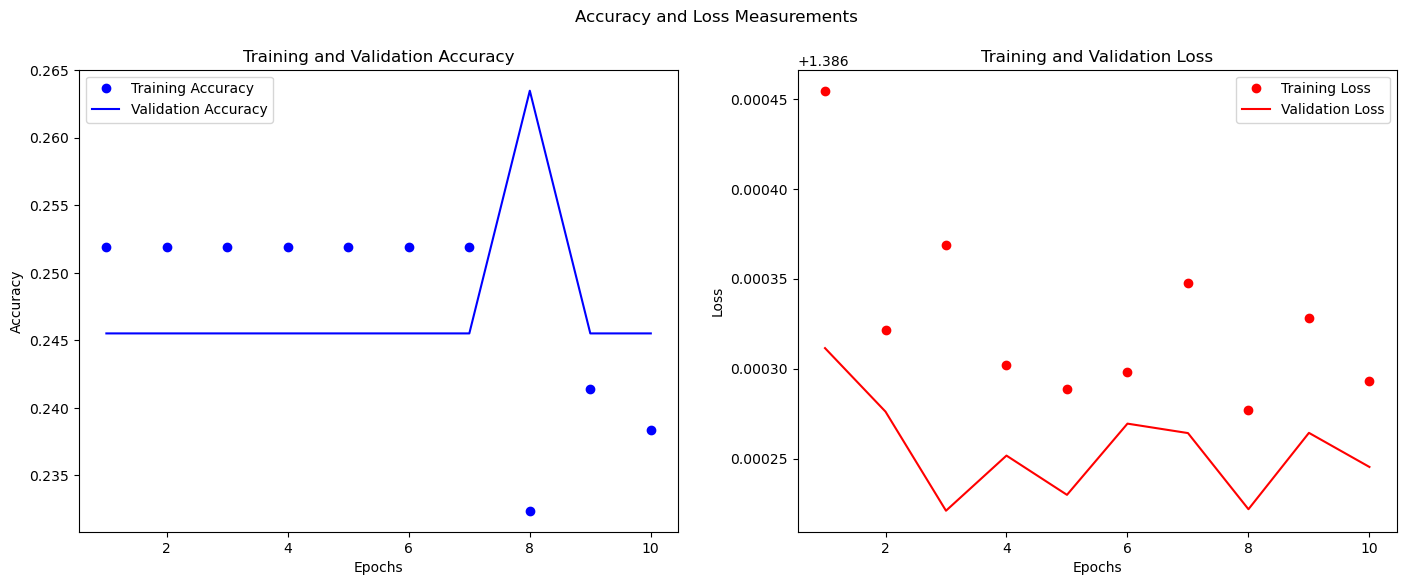

In [46]:

results_plot(history_2)

In [49]:
# 클래스 분포 확인
unique, counts = np.unique(y_test, return_counts=True)
print(f"Class distribution in test set: {dict(zip(unique, counts))}")

# 예측값 생성
y_pred_2 = model_2.predict(X_test_preprocessed)  # ConvLSTM2D 모델로 예측
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)  # 예측 클래스 추출
y_true_classes_2 = np.argmax(y_test_encoded, axis=1)  # 실제 클래스 추출


# Classification Report 출력
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("Classification Report for ConvLSTM2D Model:")
print(classification_report(y_true_classes_2, y_pred_classes_2, target_names=target_names, zero_division=0))



Class distribution in test set: {0: 50, 1: 53, 2: 46, 3: 60}
7/7 [==============================] - 1s 129ms/step
Classification Report for ConvLSTM2D Model:
              precision    recall  f1-score   support

     Class 0       0.24      1.00      0.39        50
     Class 1       0.00      0.00      0.00        53
     Class 2       0.00      0.00      0.00        46
     Class 3       0.00      0.00      0.00        60

    accuracy                           0.24       209
   macro avg       0.06      0.25      0.10       209
weighted avg       0.06      0.24      0.09       209



---
## 6.  모델 비교

3D-CNN과 ConvLSTM을 사용하여 테니스 서브 타입을 분류합니다. 이 단계에서는 각 모델의 성능을 비교하고 평가하여 더 효과적인 모델을 선정합니다.

### 모델 정확도와 손실 비교:
* Model 1 : 3D-CNN
* Model 2 : Convolutional LSTM


| Epoch | Accuracy Model 1 | Accuracy Model 2 | Loss Model 1 | Loss Model 2 |
|-------|------------------|------------------|--------------|--------------|
| 1     | 0.2114           | 0.2519           | 1.3864       | 1.3865       |
| 2     | 0.2354           | 0.2519           | 1.3863       | 1.3863       |
| 3     | 0.2534           | 0.2519           | 1.3863       | 1.3864       |
| 4     | 0.2249           | 0.2519           | 1.3863       | 1.3863       |
| 5     | 0.2534           | 0.2519           | 1.3863       | 1.3863       |
| 6     | 0.2534           | 0.2519           | 1.3863       | 1.3863       |
| 7     | 0.2534           | 0.2519           | 1.3863       | 1.3863       |
| 8     | 0.2429           | 0.2324           | 1.3863       | 1.3863       |
| 9     | 0.2534           | 0.2414           | 1.3863       | 1.3863       |
| 10    | 0.2534           | 0.2384           | 1.3864       | 1.3863       |
| Test  | 0.2536           | 0.2392           | 1.3867       | 1.3867       |
